In [53]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pickle
import gzip
from collections import OrderedDict
from pkg_resources import resource_stream
from math import log2
from ctmdata import CTM_DATASETS as _ctm_datasets, __name__ as _ctmdata_path

## Reading LBA generated data and computing symmetries

In [3]:
path = 's5_n12'

In [4]:
def load_dist_shard(filepath, entries=None):
    def line_split_read(f):
        return f.readline().strip().split(':')
    if entries is None:
        entries = {}
    with open(filepath, 'r') as f:
        _,total = line_split_read(f)
        _,halt = line_split_read(f)
        line = f.readline().strip()
        while line!='==':
            #print(line)
            st, count = line.split(':')
            #print(st, count)
            entries[st] = (st in entries and entries[st] or 0) + int(count)
            line = f.readline().strip()
    return int(total), int(halt), entries

def symmetries(bin_str, include_self=False):
    flip = lambda st: ''.join(['0' if s=='1' else '1' for s in st])
    v1 = flip(bin_str)
    v2 = v1[::-1]
    v3 = flip(v2)
    vals = {v1, v2, v3}
    if include_self:
        vals.add(bin_str)
    return list(vals)

def fill_symmetries(entries):
    flip = lambda st: ''.join(['0' if s=='1' else '1' for s in st])
    def add(k,v):
        entries[k] = (k in entries and entries[k] or 0) + v
    for bst,count in entries.copy().items():
        bst = flip(bst)
        add(bst, count)
        bst = bst[::-1]
        add(bst, count)
        bst = flip(bst)
        add(bst, count)

def count_to_D(entries, total):
    return {k:v/total for k,v in entries.items()}

def D_to_k(entries):
    return {k:-log2(v) for k,v in entries.items()}

def load_dist(dirpath,secondLevel = False,includeOneBit = True):
    entries = {}
    total = 0
    halt = 0
    files = None
    if secondLevel:
        files = [os.path.join(dirpath, folder, file) for folder in os.listdir(dirpath) for file in os.listdir(os.path.join(dirpath, folder))]
    else:
        files = [os.path.join(dirpath, file) for file in os.listdir(dirpath)]
    #return files
    for file in files:
        ctot, chalt, _ = load_dist_shard(file, entries)
        total += ctot
        halt += chalt
    fill_symmetries(entries)
    total *= 4
    halt *= 4
    nn = 5
    if includeOneBit:
        tot1halt = 2*(4*nn+2)**(2*nn-1)
        entries['0'] = entries['1'] = tot1halt
        total += 2*tot1halt
        halt += 2*tot1halt
    #dists = [load_dist_shard(os.path.join(dirpath,file)) for file in os.listdir(dirpath)]
    return total,halt,D_to_k(count_to_D(entries, halt)), entries

In [5]:
dist_total, dist_halted, dist_map, count_map = load_dist(path, secondLevel=True)

We convert our map of strings to a list:

In [7]:
dist_list = [(k,v) for k,v in dist_map.items()]
dist_list.sort(key=lambda item: item[1],reverse=False)
dist_list

[('0', 1.0620364489464673),
 ('1', 1.0620364489464673),
 ('11', 5.39104131172549),
 ('00', 5.39104131172549),
 ('01', 5.3913425549162595),
 ('10', 5.3913425549162595),
 ('001', 8.246052369497443),
 ('110', 8.246052369497443),
 ('011', 8.246052369497443),
 ('100', 8.246052369497443),
 ('111', 8.271507591258583),
 ('000', 8.271507591258583),
 ('101', 8.283723412365221),
 ('010', 8.283723412365221),
 ('0011', 11.721736115601487),
 ('1100', 11.721736115601487),
 ('0000', 11.746620697923781),
 ('1111', 11.746620697923781),
 ('0001', 11.767295498895734),
 ('1000', 11.767295498895734),
 ('1110', 11.767295498895734),
 ('0111', 11.767295498895734),
 ('1101', 11.832454643974414),
 ('0010', 11.832454643974414),
 ('1011', 11.832454643974414),
 ('0100', 11.832454643974414),
 ('0101', 11.850419672660939),
 ('1010', 11.850419672660939),
 ('0110', 11.914088123851432),
 ('1001', 11.914088123851432),
 ('00000', 16.108463568371054),
 ('11111', 16.108463568371054),
 ('01111', 16.156166196272157),
 ('10000

In [9]:
def count_len(lq):
    ans = 0
    for item in dist_list:
        if len(item[0])==lq:
            ans += 1
    return ans

In [11]:
# Get the string that represents this string in its symmetry group (the alphabetically lower)
def cannonical(st):
    eq_values = symmetries(st, include_self=True)
    eq_values.sort()
    return eq_values[0]

# Filter the distribution list to only have one string per symmetry group
def filter_canonical(dlist):
    return [tup for tup in dlist if cannonical(tup[0])==tup[0]]

In [12]:
filter_canonical(dist_list)

[('0', 1.0620364489464673),
 ('00', 5.39104131172549),
 ('01', 5.3913425549162595),
 ('001', 8.246052369497443),
 ('000', 8.271507591258583),
 ('010', 8.283723412365221),
 ('0011', 11.721736115601487),
 ('0000', 11.746620697923781),
 ('0001', 11.767295498895734),
 ('0010', 11.832454643974414),
 ('0101', 11.850419672660939),
 ('0110', 11.914088123851432),
 ('00000', 16.108463568371054),
 ('00001', 16.156166196272157),
 ('00011', 16.16793763292787),
 ('00010', 16.21651662232677),
 ('00101', 16.313028177454303),
 ('01001', 16.33599659573018),
 ('00100', 16.34214996328433),
 ('01010', 16.356945654914817),
 ('00110', 16.391376044743033),
 ('01110', 16.45603828523194),
 ('000000', 22.498134972748403),
 ('000001', 22.68076509611899),
 ('000011', 22.794700015112912),
 ('000111', 22.819206342980955),
 ('000010', 22.819937196377417),
 ('010101', 22.959029537541387),
 ('000101', 23.14691829594347),
 ('000100', 23.226930313433748),
 ('001001', 23.260363587461722),
 ('001010', 23.261813532348484),


## Basic LBA distribution visualization

In [15]:
def showDist(lst=None, figsize=(12,6), minlen=1, maxlen=200):
    if lst is None:
        lst = dist_list
    plt.figure(figsize=figsize)
    #lens = [len(item[0]) for item in dist_list]
    plt.scatter([item[0] for item in lst if len(item[0])>=minlen and len(item[0])<=maxlen], [item[1] for item in lst if len(item[0])>=minlen and len(item[0])<=maxlen])
    plt.xticks(fontsize = 6)
    plt.show()

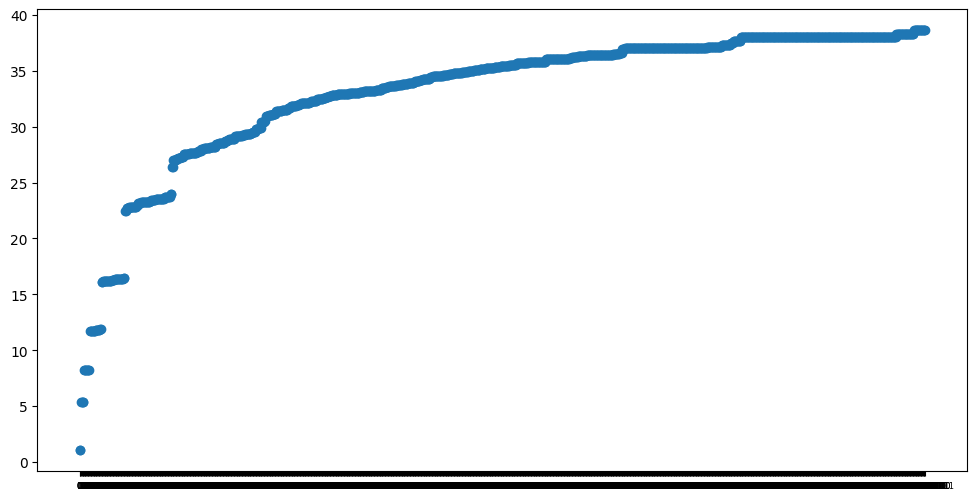

In [ ]:
showDist()

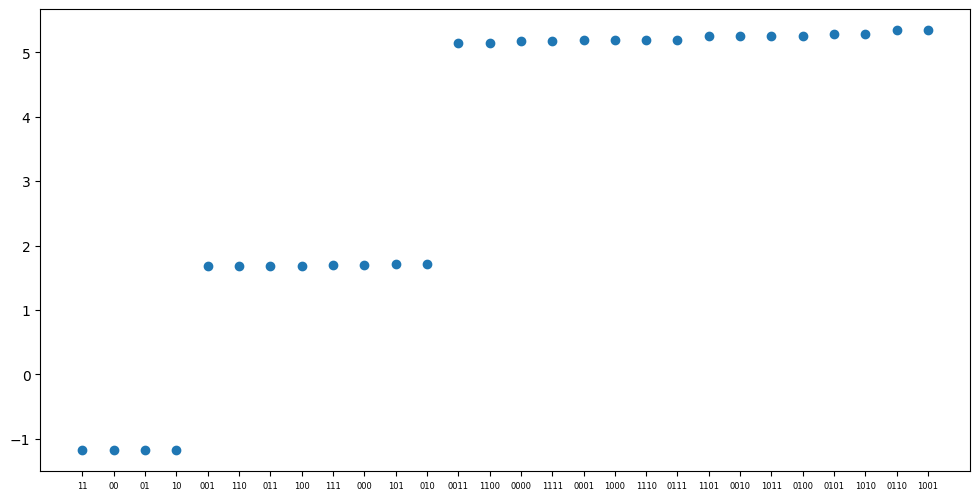

In [ ]:
showDist(maxlen=4)

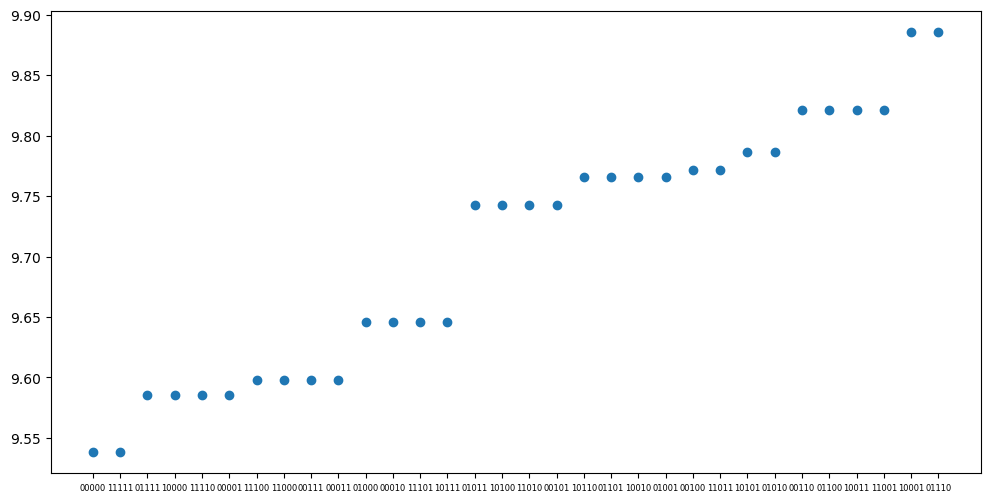

In [ ]:
showDist(minlen=5,maxlen=5)

## Reading TM distribution from BDM dataset

In [23]:
def load_data(name):
    if name not in _ctm_datasets:
        raise ValueError("There is no {} CTM dataset".format(name))
    with resource_stream(_ctmdata_path, _ctm_datasets[name]) as stream:
        dct = pickle.loads(gzip.decompress(stream.read()))
        #print(dct)
    for key in dct:
        o = dct[key]
        #dct[key] = OrderedDict(sorted(o.items(), key=lambda x: x[1], reverse=True))
    missing = {}
    for sh, cmx in dct.items():
        missing[sh] = np.max(list(cmx.values())) + 1
    return dct, missing

In [24]:
data,miss = load_data('CTM-B2-D12')
ctm_list = [(st,v) for k,vs in data.items() for st,v in vs.items() if len(st)>1]
ctm_list

[('00', 3.3274392037713696),
 ('01', 3.3274392037713696),
 ('010', 5.505382835204287),
 ('001', 5.445775723159447),
 ('011', 5.445775723159447),
 ('000', 5.396192979238844),
 ('0110', 8.406713544643704),
 ('0011', 8.339204441401838),
 ('0101', 8.258704003348441),
 ('0010', 8.257635135042214),
 ('0100', 8.257635135042214),
 ('0001', 8.18700578068948),
 ('0111', 8.18700578068948),
 ('0000', 7.930827983517139),
 ('01110', 11.834019495714655),
 ('00110', 11.680261522851328),
 ('01100', 11.680261522851328),
 ('00011', 11.623520075205388),
 ('00111', 11.623520075205388),
 ('00101', 11.558487139821473),
 ('01011', 11.558487139821473),
 ('01010', 11.537843772656387),
 ('01001', 11.508973997347594),
 ('01101', 11.508973997347594),
 ('00100', 11.430487601155338),
 ('00010', 11.322044936911597),
 ('01000', 11.322044936911597),
 ('00001', 11.216342286640861),
 ('01111', 11.216342286640861),
 ('00000', 10.712578829976554),
 ('001110', 15.36633169778009),
 ('011100', 15.36633169778009),
 ('000111', 

## Visualizing/comparing TM with LBA

We start by checking how many strings were computer on both models

In [26]:
def count_missing_entries(dist):
    vdict = {tup[0]:tup[1] for tup in dist}
    for lens in range(2, 13):
        print(f'Strings with len {lens}')
        count = 0
        total = 2**lens
        for dec in range(0, 2**lens):
            binv = bin(dec)[2:]
            binv = '0'*(lens-len(binv)) + binv
            binv = cannonical(binv)
            if binv not in vdict:
                count += 1
        print(f'\tMissing {count}/{total}\t {count*100/total}%')


In [27]:
count_missing_entries(dist_list) #LBA

Strings with len 2
	Missing 0/4	 0.0%
Strings with len 3
	Missing 0/8	 0.0%
Strings with len 4
	Missing 0/16	 0.0%
Strings with len 5
	Missing 0/32	 0.0%
Strings with len 6
	Missing 0/64	 0.0%
Strings with len 7
	Missing 0/128	 0.0%
Strings with len 8
	Missing 0/256	 0.0%
Strings with len 9
	Missing 166/512	 32.421875%
Strings with len 10
	Missing 816/1024	 79.6875%
Strings with len 11
	Missing 1986/2048	 96.97265625%
Strings with len 12
	Missing 4068/4096	 99.31640625%


In [28]:
count_missing_entries(ctm_list) #TM

Strings with len 2
	Missing 0/4	 0.0%
Strings with len 3
	Missing 0/8	 0.0%
Strings with len 4
	Missing 0/16	 0.0%
Strings with len 5
	Missing 0/32	 0.0%
Strings with len 6
	Missing 0/64	 0.0%
Strings with len 7
	Missing 0/128	 0.0%
Strings with len 8
	Missing 0/256	 0.0%
Strings with len 9
	Missing 0/512	 0.0%
Strings with len 10
	Missing 0/1024	 0.0%
Strings with len 11
	Missing 0/2048	 0.0%
Strings with len 12
	Missing 0/4096	 0.0%


Now the plots comparing distributions

In [29]:
def keyAndDictForLists(ctm_list, dist_list, limitLen = None):
    ctm_dict = {v[0]:v[1] for v in ctm_list}
    dist_dict = {v[0]:v[1] for v in dist_list}
    keys = list(set(ctm_dict.keys()) & set(dist_dict.keys()))
    if limitLen is not None:
        keys = [key for key in keys if len(key)<=limitLen]
    return ctm_dict, dist_dict, keys

def plotDistributions(ctm_list, dist_list, limitLen = None):
    ctm_dict, dist_dict, keys = keyAndDictForLists(ctm_list, dist_list, limitLen)
    keys.sort(key=lambda item: (len(item),int(item, 2)),reverse=False)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.scatter(keys, [ctm_dict[k] for k in keys],label='TM')
    ax.scatter(keys, [dist_dict[k] for k in keys],label='LBA')
    ax.legend()
    plt.show()

def plotIncreasingLine(ctm_list, dist_list, sortByTM = True, limitLen = None):
    ctm_dict, dist_dict, keys = keyAndDictForLists(ctm_list, dist_list, limitLen)
    sortdict = sortByTM and ctm_dict or dist_dict
    keys.sort(key=lambda item: sortdict[item],reverse=False)
    plt.plot([ctm_dict[k] for k in keys],label='TM')
    plt.plot([dist_dict[k] for k in keys],label='LBA')
    plt.legend()
    plt.show()

def plotCorrelation(ctm_list, dist_list, sortByTM = True, limitLen = None):
    ctm_dict, dist_dict, keys = keyAndDictForLists(ctm_list, dist_list, limitLen)
    xs = np.array([dist_dict[k] for k in keys])
    ys = np.array([ctm_dict[k] for k in keys])
    slope, intercept = np.polyfit(xs, ys, 1)
    plt.scatter(xs, ys)
    plt.plot(xs, slope*xs + intercept, color='red')
    plt.xlabel('LBA-CTM')
    plt.ylabel('TM-CTM')
    plt.legend()

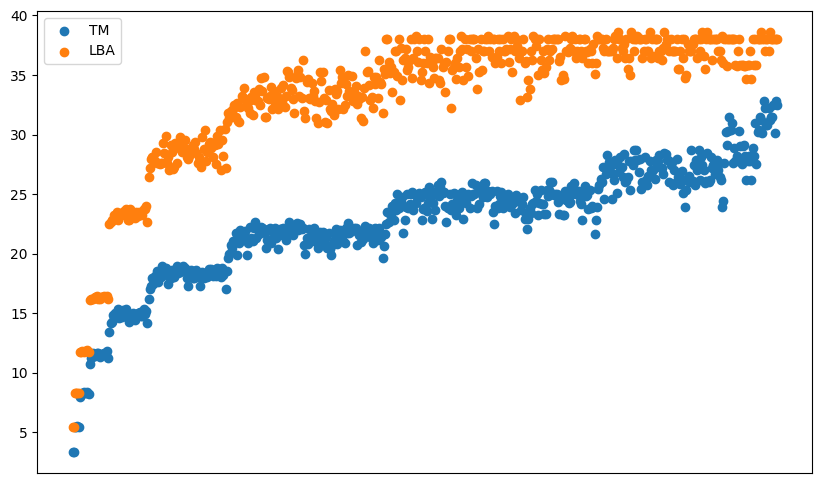

In [30]:
plotDistributions(ctm_list, dist_list)

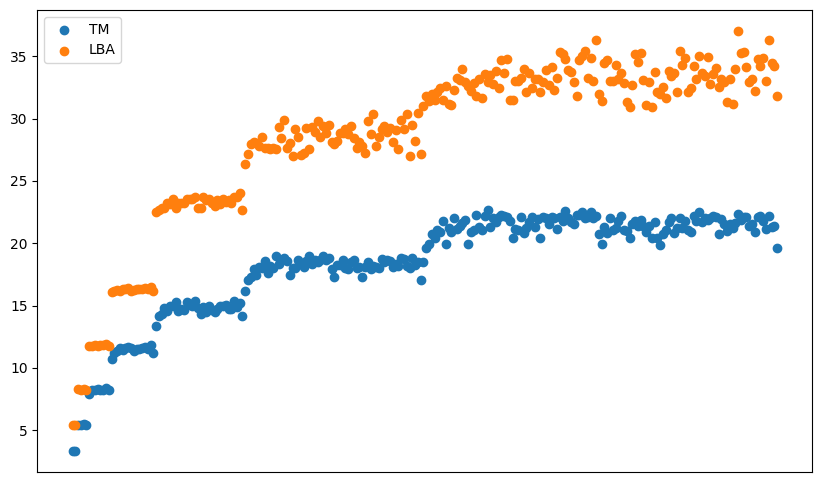

In [ ]:
plotDistributions(ctm_list, dist_list, limitLen = 8)

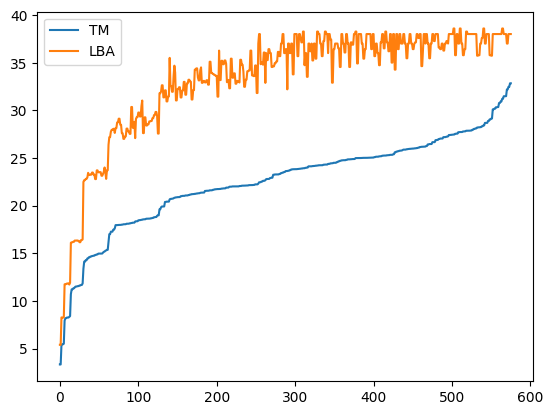

In [ ]:
plotIncreasingLine(ctm_list, dist_list)

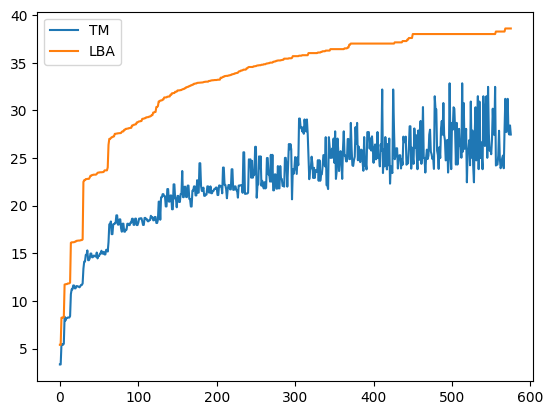

In [ ]:
plotIncreasingLine(ctm_list, dist_list, sortByTM = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


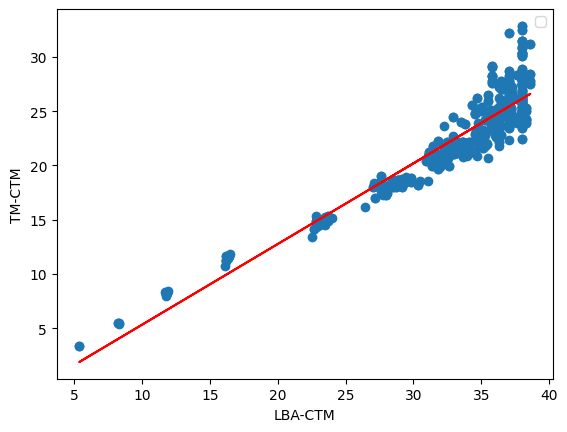

In [ ]:
plotCorrelation(ctm_list, dist_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


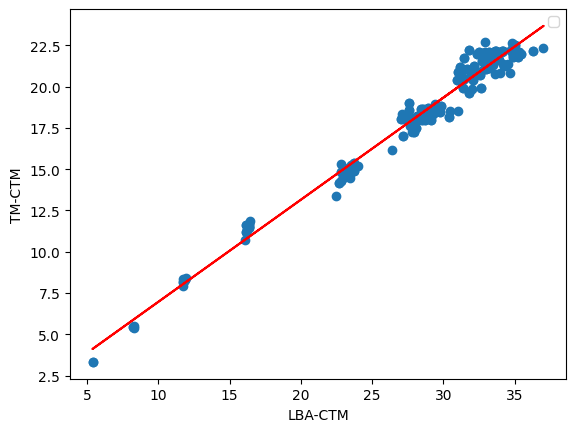

In [ ]:
plotCorrelation(ctm_list, dist_list, limitLen = 8)

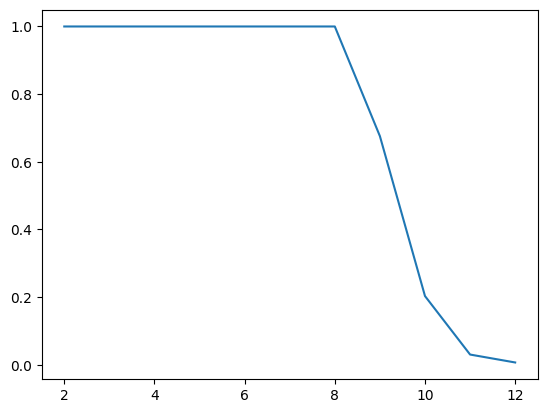

In [ ]:
vals = [i for i in range(2,13)]
plt.plot(vals, [count_len(i)/(2**i) for i in vals])

## Saving LBA distribution for BDM format

In [21]:
def serialize_and_compress(data, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(data, f)

def save_data(values, name):
    data = {}

    for v in values:
        mk = (len(v[0]),)
        if not mk in data:
            data[mk] = []
        data[mk].append(v)
    data = OrderedDict({k:OrderedDict(v) for k,v in data.items()})
    serialize_and_compress(data, os.path.join(_ctmdata_path, name))
    return data
   # return convert_to_defaultdict(x)

In [25]:
data = save_data(dist_list, 'lba-b2.pkl.gz')
#data = save_data(filter_canonical(dist_list), 'lba-b2.pkl.gz')
data

OrderedDict([((1,),
              OrderedDict([('0', 1.0620364489464673),
                           ('1', 1.0620364489464673)])),
             ((2,),
              OrderedDict([('11', 5.39104131172549),
                           ('00', 5.39104131172549),
                           ('01', 5.3913425549162595),
                           ('10', 5.3913425549162595)])),
             ((3,),
              OrderedDict([('001', 8.246052369497443),
                           ('110', 8.246052369497443),
                           ('011', 8.246052369497443),
                           ('100', 8.246052369497443),
                           ('111', 8.271507591258583),
                           ('000', 8.271507591258583),
                           ('101', 8.283723412365221),
                           ('010', 8.283723412365221)])),
             ((4,),
              OrderedDict([('0011', 11.721736115601487),
                           ('1100', 11.721736115601487),
                           ('0000

Testing the saved file:

In [55]:
data,miss = load_data('lba-b2')
[(st,v) for k,vs in data.items() for st,v in vs.items() if len(st)>1]

[('11', 5.39104131172549),
 ('00', 5.39104131172549),
 ('01', 5.3913425549162595),
 ('10', 5.3913425549162595),
 ('001', 8.246052369497443),
 ('110', 8.246052369497443),
 ('011', 8.246052369497443),
 ('100', 8.246052369497443),
 ('111', 8.271507591258583),
 ('000', 8.271507591258583),
 ('101', 8.283723412365221),
 ('010', 8.283723412365221),
 ('0011', 11.721736115601487),
 ('1100', 11.721736115601487),
 ('0000', 11.746620697923781),
 ('1111', 11.746620697923781),
 ('0001', 11.767295498895734),
 ('1000', 11.767295498895734),
 ('1110', 11.767295498895734),
 ('0111', 11.767295498895734),
 ('1101', 11.832454643974414),
 ('0010', 11.832454643974414),
 ('1011', 11.832454643974414),
 ('0100', 11.832454643974414),
 ('0101', 11.850419672660939),
 ('1010', 11.850419672660939),
 ('0110', 11.914088123851432),
 ('1001', 11.914088123851432),
 ('00000', 16.108463568371054),
 ('11111', 16.108463568371054),
 ('01111', 16.156166196272157),
 ('10000', 16.156166196272157),
 ('11110', 16.156166196272157),


## MISC (WIP/DRAFT)

In [33]:
count_map['00'],count_map['11']

(120136177104, 120136177104)

In [34]:
count_map['11111'],count_map['10011']

(71352342, 58646634)

In [ ]:
def reduceKey(n, m):
    if n > m/2:
        n = m-n
    for i in range(2,7):
        while n%i==0 and m%i==0:
            n /= i
            m /= i
    return round(n/m, 2)

def complexitiesPerRatio(dlist):
    counts = {}
    avgs = {}
    values = {}
    ratios = []
    for i in range(len(dlist)):
        v = dlist[i]
        key = reduceKey(v[0].count('0'), len(v[0]))
        if not key in values:
            avgs[key] = counts[key] = 0
            values[key] = []
        avgs[key] += v[1]
        counts[key] += 1
        ratios.append(key)
        values[key].append(i)
    plt.figure(figsize=(16,8))
    keys = avgs.keys()
    for k in keys:
        avgs[k] /= counts[k]
    
    #plt.scatter(keys, [avgs[key] for key in keys])
    
    #plt.scatter(ratios, [v[1] for v in dlist])
    
    for k, indexes in values.items():
        indexes.sort(key=lambda i: len(dlist[i][0]), reverse=False)
        #lens = [len(dlist[i][0]) for i in indexes]
        lastV = -1
        csum = 0
        ccount = 0
        lenavgs = {}
        for i in indexes:
            vl = len(dlist[i][0])
            if vl != lastV:
                if lastV != -1:
                    lenavgs[lastV] = csum / ccount
                lastV = vl
                csum = ccount = 0
            csum += dlist[i][1]
            ccount += 1
        lenavgs[lastV] = csum / ccount
        lens = lenavgs.keys()
        vals = [lenavgs[vlen] for vlen in lens]
        #vals = [dlist[i][1] for i in indexes]
        plt.plot(lens, vals, label=str(k))
    plt.legend()
    #sns.violinplot(
    #    x = ratios,
    #    y = [v[1] for v in dlist]
    #)